# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [15]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import Subset
import numpy as np


In [2]:
from myResNet.MyResnet import MyResNet
from Trainer.Trainer import Trainer
from OOD.OOD_utils import OOD_pipeline, FGSM

In [3]:
layers_deeper_net = [
    ("Conv2d", 3, 64, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 64),
    ("Conv2d", 64, 64, 3, 1, 1, "zeros", "ReLU"),
    ("Dropout", 0.5),
    ("BatchNorm2d", 64),
    ("MaxPool2d", 2),

    ("Conv2d", 64, 128, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 128),
    ("Conv2d", 128, 128, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 128),
    ("MaxPool2d", 2),

    ("Conv2d", 128, 256, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 256),
    ("Conv2d", 256, 256, 3, 1, 1, "zeros", "ReLU"),
    ("BatchNorm2d", 256),
    ("MaxPool2d", 2),

    ("Linear", 4096, 512, 1, 256, "ReLU"),
    ("Dropout", 0.5),
    ("Linear", 256, 128, 2, 10)
]

best_CNN = MyResNet(layers_deeper_net, data_shape=(3,32,32),skip_dict={1:4,4:7,7:9,9:12,12:14})
best_CNN.load_state_dict(torch.load("/home/tommaso/Documents/deep_learning/bestCNNv2.pth", weights_only = True)) 

<All keys matched successfully>

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

transform_CIFAR100 = transforms.Compose([transforms.ToTensor(),
                      transforms.Normalize(mean=[0.5071, 0.4865, 0.4409],std=[0.2673, 0.2564, 0.2762])])



batch_size = 128


ds_train = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

ds_test = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

ds_OOD = CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_CIFAR100
)

Test set loss: 0.4854, accuracy: 0.8681


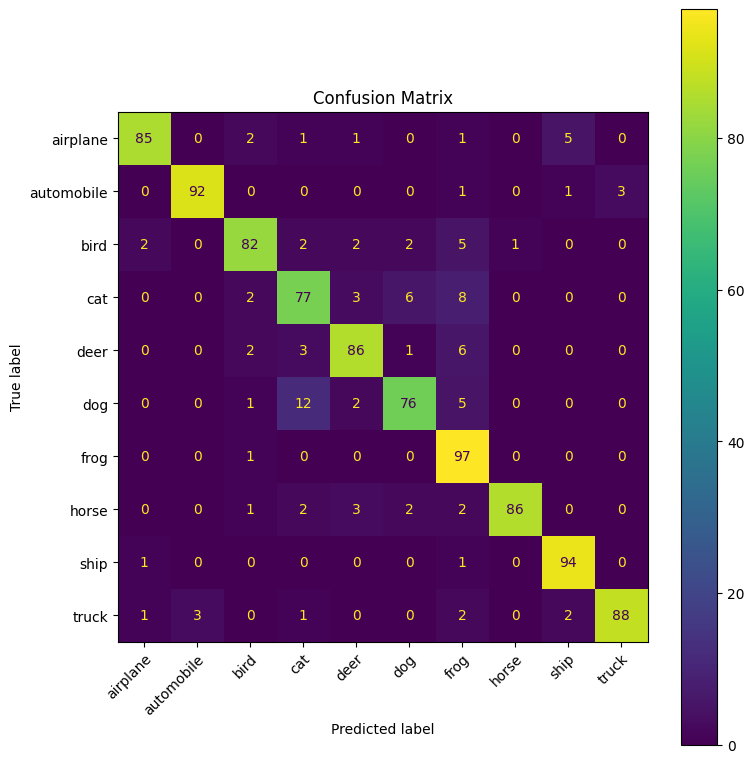

(0.4853750726699829, 0.8681)

In [5]:
best_CNN.test(ds_test,plot=True)

In [5]:
ID_objects = ds_test.classes
CIFAR100_classes = ds_OOD.classes

cifar100_to_cifar10 = {
    # superclasse: aquatic mammals
    'beaver': None,
    'dolphin': None,
    'otter': None,
    'seal': None,
    'whale': None,

    # fish
    'aquarium_fish': None,
    'flatfish': None,
    'ray': None,
    'shark': None,
    'trout': None,

    # flowers
    'orchid': None,
    'poppy': None,
    'rose': None,
    'sunflower': None,
    'tulip': None,

    # food containers
    'bottle': None,
    'bowl': None,
    'can': None,
    'cup': None,
    'plate': None,

    # fruit and vegetables
    'apple': None,
    'mushroom': None,
    'orange': None,
    'pear': None,
    'sweet_pepper': None,

    # household electrical devices
    'clock': None,
    'keyboard': None,
    'lamp': None,
    'telephone': None,
    'television': None,

    # household furniture
    'bed': None,
    'chair': None,
    'couch': None,
    'table': None,
    'wardrobe': None,

    # insects
    'bee': None,
    'beetle': None,
    'butterfly': None,
    'caterpillar': None,
    'cockroach': None,

    # large carnivores
    'bear': None,
    'leopard': None,
    'lion': None,
    'tiger': None,
    'wolf': None,

    # large man-made outdoor things
    'bridge': None,
    'castle': None,
    'house': None,
    'road': None,
    'skyscraper': None,

    # large natural outdoor scenes
    'cloud': None,
    'forest': None,
    'mountain': None,
    'plain': None,
    'sea': None,

    # large omnivores and herbivores
    'camel': None,
    'cattle': None,
    'chimpanzee': None,
    'elephant': None,
    'kangaroo': None,

    # medium-sized mammals
    'fox': None,
    'porcupine': None,
    'possum': None,
    'raccoon': None,
    'skunk': None,

    # non-insect invertebrates
    'crab': None,
    'lobster': None,
    'snail': None,
    'spider': None,
    'worm': None,

    # people
    'baby': None,
    'boy': None,
    'girl': None,
    'man': None,
    'woman': None,

    # reptiles
    'crocodile': None,
    'dinosaur': None,
    'lizard': None,
    'snake': None,
    'turtle': None,

    # small mammals
    'hamster': None,
    'mouse': None,
    'rabbit': None,
    'shrew': None,
    'squirrel': None,

    # trees
    'maple_tree': None,
    'oak_tree': None,
    'palm_tree': None,
    'pine_tree': None,
    'willow_tree': None,

    # vehicles 1
    'bicycle': 'automobile',
    'bus': 'automobile',
    'motorcycle': 'automobile',
    'pickup_truck': 'truck',
    'train': None,

    # vehicles 2
    'lawn_mower': None,
    'rocket': None,
    'streetcar': None,
    'tank': None,
    'tractor': None,

    # birds
    'parrot': 'bird',
    'woodpecker': 'bird',

    # cats
    'tiger_cat': 'cat',
    'house_cat': 'cat',

    # dogs
    'wolf': None,  # lupo selvatico -> no
    'fox': None,
    'coyote': None,
    'dingo': None,

    # frogs
    'frog': 'frog',

    # horses
    'horse': 'horse',

    # ships & planes
    'airplane': 'airplane',
    'warplane': 'airplane',
    'ship': 'ship',
    'airliner': 'airplane',

    # trucks
    'pickup_truck': 'truck',
    'tank_truck': 'truck',
}


indexes_OOD = []

for example_index in range(len(ds_OOD)):
    
    example = ds_OOD[example_index]
    label = CIFAR100_classes[example[1]]

    if cifar100_to_cifar10[label] == None:
        indexes_OOD.append(example_index)

OOD_classes = []

for k,v in cifar100_to_cifar10.items():
    if v == None:
        OOD_classes.append(k)

ds_OOD = Subset(ds_OOD,indexes_OOD)
ds_OOD = ds_OOD.dataset
ds_OOD.classes = OOD_classes
print(len(ds_OOD))
print(ds_OOD.classes)

50000
['beaver', 'dolphin', 'otter', 'seal', 'whale', 'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout', 'orchid', 'poppy', 'rose', 'sunflower', 'tulip', 'bottle', 'bowl', 'can', 'cup', 'plate', 'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper', 'clock', 'keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 'bear', 'leopard', 'lion', 'tiger', 'wolf', 'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree', 'train', 'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor', 'coyote', 'dingo

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



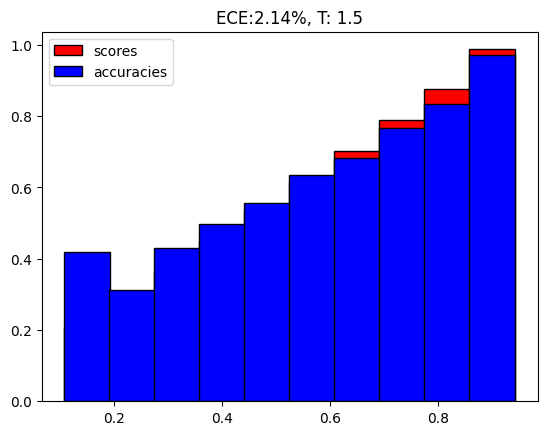

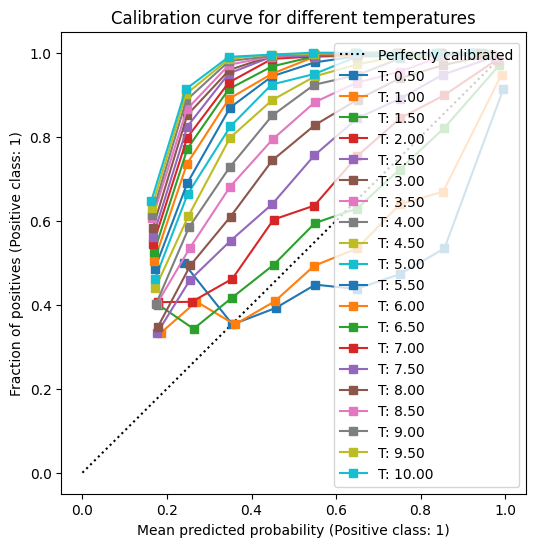

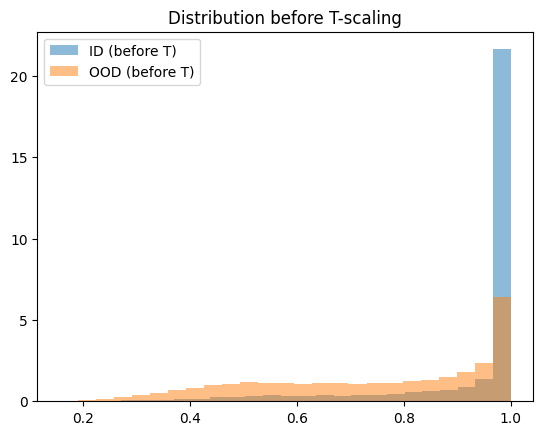

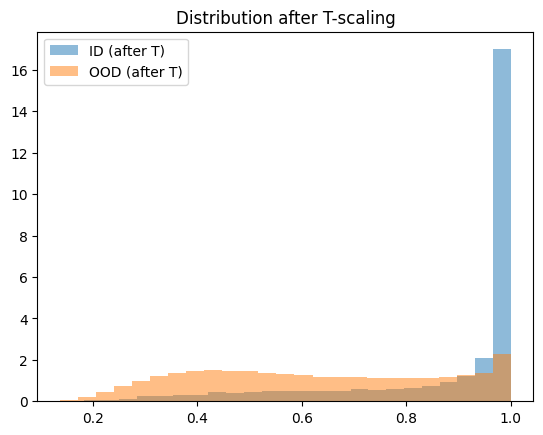

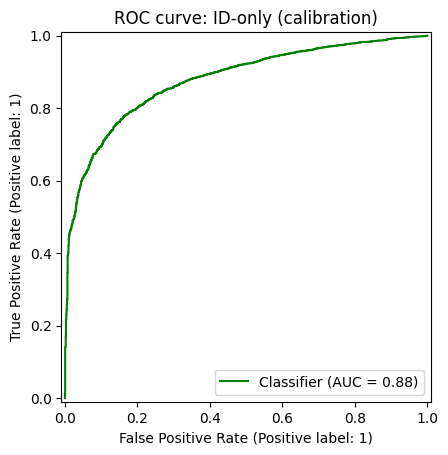

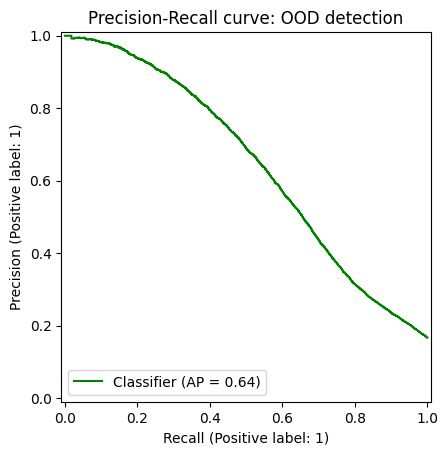

(1.5, 0.021424083672463894)

In [6]:
###see complete pipeline above####
T_scaling = [x/10 for x in range(5,105,5)]
OOD_pipeline(best_CNN,'cuda',ds_test,ds_OOD,128,4, T_scaling=T_scaling, plot_T_scaling=True, plot_performances=False)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [33]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [11]:
for i,c in enumerate(ds_train.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6660709..1.8671108].


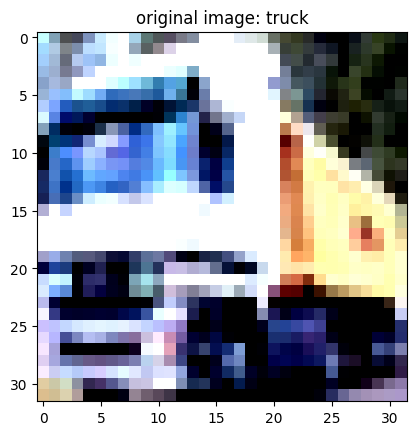

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


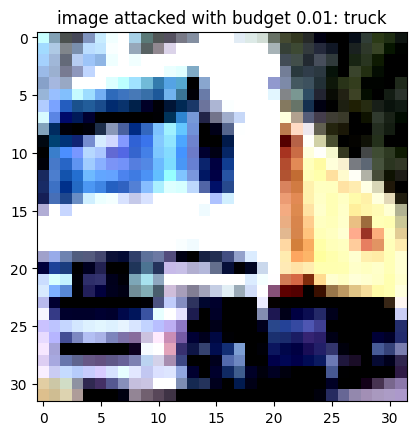

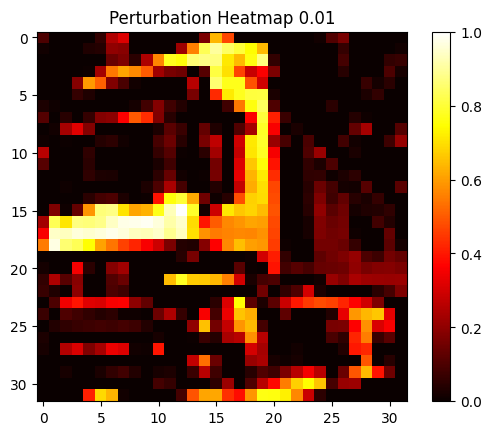

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


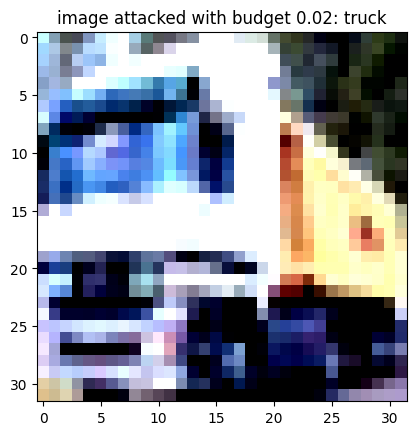

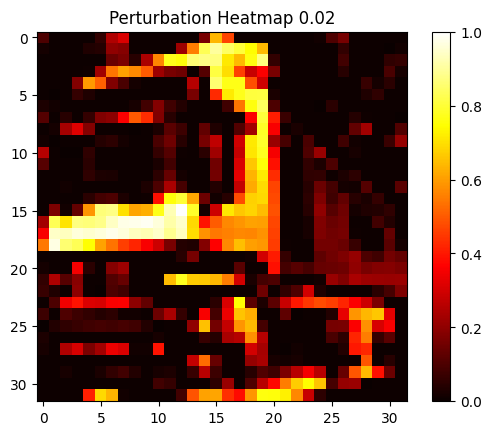

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


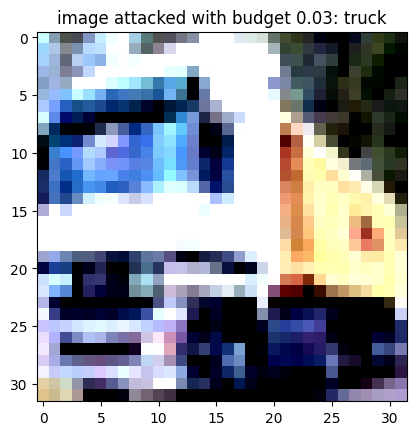

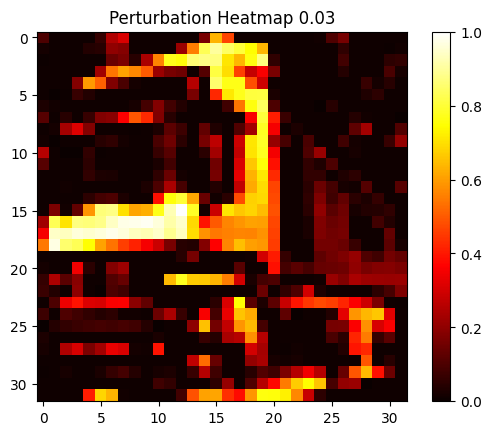

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


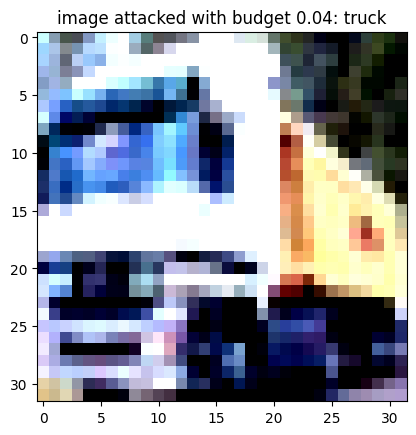

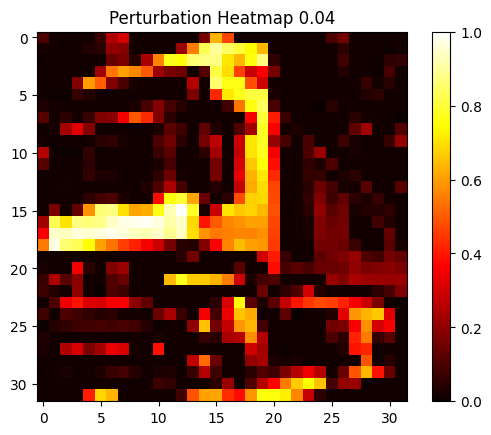

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


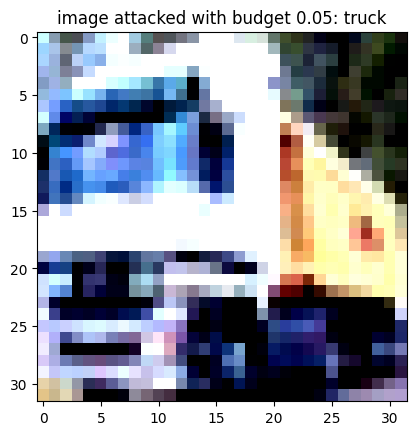

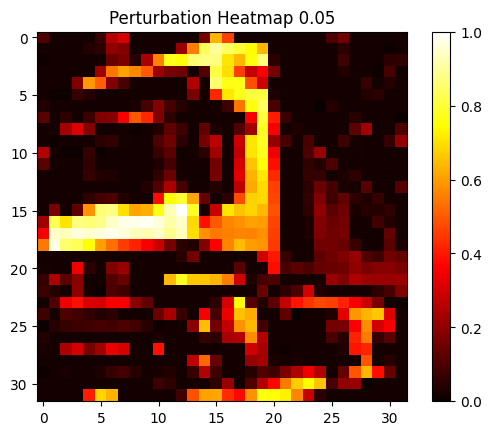

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


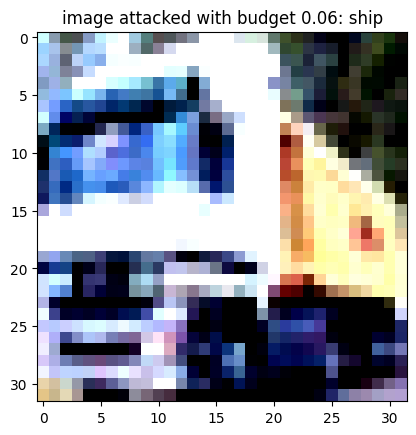

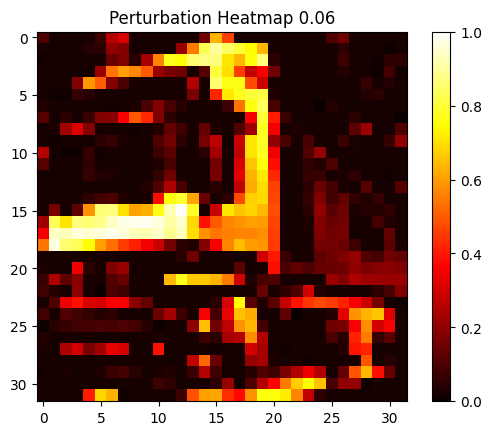

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


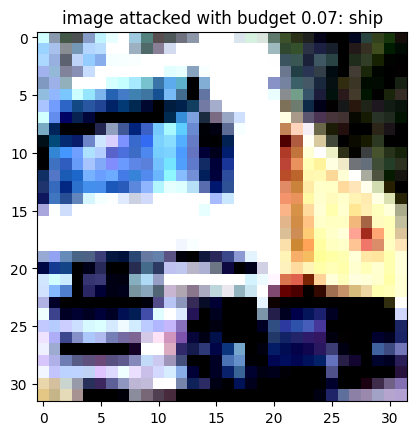

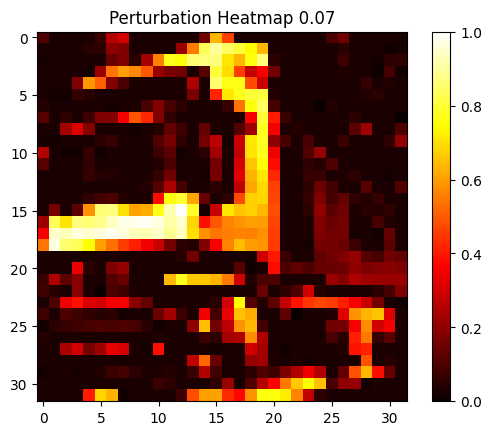

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


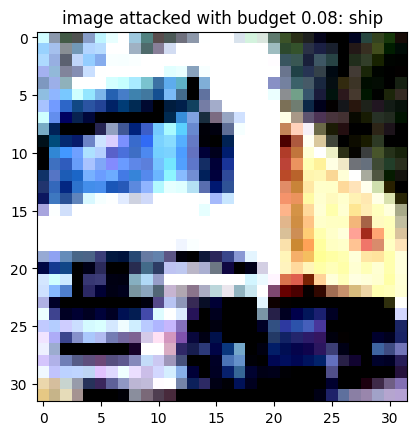

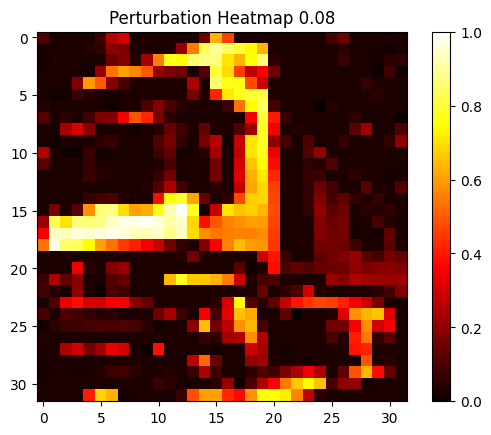

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


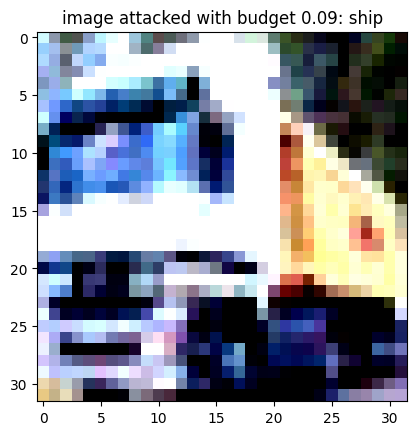

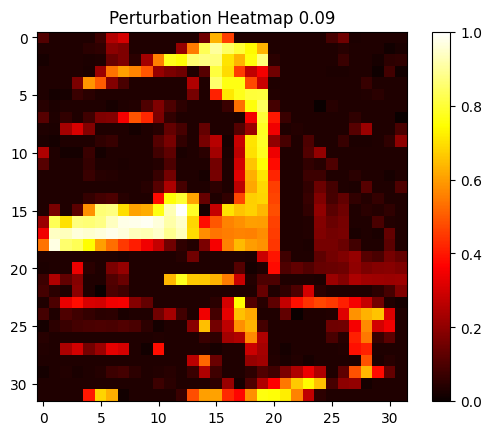

In [9]:
####untargeted FGSM evaluation (see fgsm function in training file)
example = ds_train[1]

device = 'cuda'

best_CNN.to(device)


best_CNN.eval()
output_clean = best_CNN(example[0].unsqueeze(0).to(device))

img = inv(example[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title('original image' + ': ' + str(ds_train.classes[output_clean.argmax()]))
plt.show()



#qualitative evaluation
for budget in range(1,10,1):
    budget = budget/100
    x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_true = example[1],model =best_CNN,budget = budget)
    output = best_CNN(x_adv.to(device))

    img_adv = inv(x_adv[0])
    plt.imshow(img_adv.permute(1,2,0).detach().cpu())
    plt.title('image attacked with budget' +' ' + str(budget) + ': ' + ds_train.classes[output.argmax()])
    plt.show()

    diff = (x_adv.cpu() - example[0]).squeeze(0)

    heatmap = diff.abs().sum(dim=0)
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    plt.imshow(heatmap.detach().cpu(), cmap='hot')
    plt.title("Perturbation Heatmap" + ' ' + str(budget))
    plt.colorbar()
    plt.show()


In [29]:
# Quantitative evaluation
device = 'cuda'
best_CNN.to(device).eval()

# Budget values
budgets = [b / 1000 for b in range(1, 50, 2)]

correctly_classified = []
idx = 0
while len(correctly_classified) < 100:
    x, y = ds_train[idx]
    with torch.no_grad():
        output = best_CNN(x.unsqueeze(0).to(device))
    if output.argmax().item() == y:
        correctly_classified.append((x, y))
    idx += 1

psnr_list = []

# Calcolo PSNR per ogni budget
for eps in budgets:
    psnr_sum = 0.0
    for x, y in correctly_classified:
        x = x.unsqueeze(0).to(device)
        x_adv = FGSM(x=x, y_true=int(y), model=best_CNN, budget=eps)

        # MSE e PSNR
        mse = F.mse_loss(x_adv, x).item()
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 10.0 * np.log10(4.0 / mse)  
        psnr_sum += psnr

    # Media sui 100 esempi
    psnr_list.append(psnr_sum / len(correctly_classified))


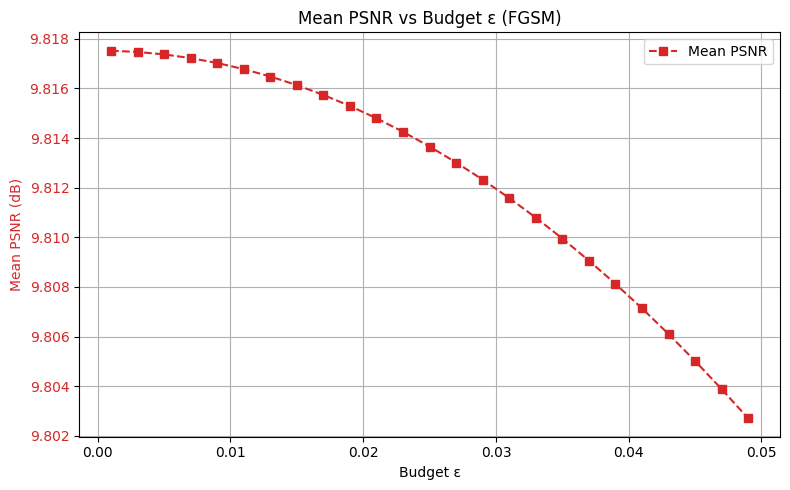

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

color_psnr = 'tab:red'
ax.set_xlabel('Budget ε')
ax.set_ylabel('Mean PSNR (dB)', color=color_psnr)
ax.plot(budgets, psnr_list, marker='s', linestyle='--', color=color_psnr, label='Mean PSNR')
ax.tick_params(axis='y', labelcolor=color_psnr)

plt.title('Mean PSNR vs Budget ε (FGSM)')
plt.grid(True)
ax.legend(loc='best')

plt.tight_layout()
plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [9]:
trainer_config = {
    "device": 'cuda', 
    "num_workers": 4, 
    "seed": 42
}
augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

new_model = MyResNet(layers_deeper_net, data_shape=(3,32,32),skip_dict={1:4,4:7,7:9,9:12,12:14})


trainer = Trainer(config=trainer_config, model=new_model,optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3, weight_decay=1e-4),dataset=ds_train, lr=0.001)
trainer.train(data_split=[0.2, 0.8], batch_size=64, num_epochs=65, early_stopping=3, val_check=3, use_wandb=False, augmentation=(0.4,augment), checks=False, fgsm = [0.01])

running on device cuda


Training epoch 0: 100%|██████████| 875/875 [00:23<00:00, 37.40it/s]

Epoch 0/65, Average training loss: 1.6484


Epoch 0/65, Training accuracy: 0.4644


Validation epoch 0: 100%|██████████| 157/157 [00:00<00:00, 178.34it/s]

Epoch 0/65, Average validation loss: 1.3555


Epoch 0/65, Validation accuracy: 0.4565


Training epoch 1: 100%|██████████| 875/875 [00:23<00:00, 37.20it/s]

Epoch 1/65, Average training loss: 1.2829


Epoch 1/65, Training accuracy: 0.5933


Training epoch 2: 100%|██████████| 875/875 [00:23<00:00, 36.88it/s]

Epoch 2/65, Average training loss: 1.0743


Epoch 2/65, Training accuracy: 0.5589


Training epoch 3: 100%|██████████| 875/875 [00:23<00:00, 36.49it/s]

Epoch 3/65, Average training loss: 0.9265


Epoch 3/65, Training accuracy: 0.6631


Validation epoch 3: 100%|██████████| 157/157 [00:00<00:00, 171.09it/s]

Epoch 3/65, Average validation loss: 0.8107


Epoch 3/65, Validation accuracy: 0.6599


Training epoch 4: 100%|██████████| 875/875 [00:24<00:00, 36.25it/s]

Epoch 4/65, Average training loss: 0.8280


Epoch 4/65, Training accuracy: 0.6291


Training epoch 5: 100%|██████████| 875/875 [00:24<00:00, 36.09it/s]

Epoch 5/65, Average training loss: 0.7599


Epoch 5/65, Training accuracy: 0.6732


Training epoch 6: 100%|██████████| 875/875 [00:24<00:00, 36.02it/s]

Epoch 6/65, Average training loss: 0.7055


Epoch 6/65, Training accuracy: 0.7495


Validation epoch 6: 100%|██████████| 157/157 [00:00<00:00, 174.25it/s]

Epoch 6/65, Average validation loss: 0.6888


Epoch 6/65, Validation accuracy: 0.7264


Training epoch 7: 100%|██████████| 875/875 [00:24<00:00, 36.05it/s]

Epoch 7/65, Average training loss: 0.6582


Epoch 7/65, Training accuracy: 0.7370


Training epoch 8: 100%|██████████| 875/875 [00:24<00:00, 35.66it/s]

Epoch 8/65, Average training loss: 0.6211


Epoch 8/65, Training accuracy: 0.7387


Training epoch 9: 100%|██████████| 875/875 [00:24<00:00, 35.34it/s]

Epoch 9/65, Average training loss: 0.5860


Epoch 9/65, Training accuracy: 0.7332


Validation epoch 9: 100%|██████████| 157/157 [00:00<00:00, 163.76it/s]

Epoch 9/65, Average validation loss: 0.6013


Epoch 9/65, Validation accuracy: 0.7360


Training epoch 10: 100%|██████████| 875/875 [00:24<00:00, 35.30it/s]

Epoch 10/65, Average training loss: 0.5601


Epoch 10/65, Training accuracy: 0.7266


Training epoch 11: 100%|██████████| 875/875 [00:24<00:00, 35.04it/s]

Epoch 11/65, Average training loss: 0.5323


Epoch 11/65, Training accuracy: 0.6984


Training epoch 12: 100%|██████████| 875/875 [00:24<00:00, 35.11it/s]

Epoch 12/65, Average training loss: 0.5088


Epoch 12/65, Training accuracy: 0.6853


Validation epoch 12: 100%|██████████| 157/157 [00:00<00:00, 159.66it/s]

Epoch 12/65, Average validation loss: 0.5897


Epoch 12/65, Validation accuracy: 0.7430


Training epoch 13: 100%|██████████| 875/875 [00:24<00:00, 35.26it/s]

Epoch 13/65, Average training loss: 0.4890


Epoch 13/65, Training accuracy: 0.7525


Training epoch 14: 100%|██████████| 875/875 [00:24<00:00, 35.03it/s]

Epoch 14/65, Average training loss: 0.4703


Epoch 14/65, Training accuracy: 0.7181


Training epoch 15: 100%|██████████| 875/875 [00:24<00:00, 35.04it/s]

Epoch 15/65, Average training loss: 0.4582


Epoch 15/65, Training accuracy: 0.6810


Validation epoch 15: 100%|██████████| 157/157 [00:01<00:00, 135.63it/s]

Epoch 15/65, Average validation loss: 0.5923


Epoch 15/65, Validation accuracy: 0.7652


Training epoch 16: 100%|██████████| 875/875 [00:26<00:00, 33.46it/s]

Epoch 16/65, Average training loss: 0.4469


Epoch 16/65, Training accuracy: 0.6676


Training epoch 17: 100%|██████████| 875/875 [00:25<00:00, 34.57it/s]

Epoch 17/65, Average training loss: 0.4246


Epoch 17/65, Training accuracy: 0.6931


Training epoch 18: 100%|██████████| 875/875 [00:24<00:00, 35.05it/s]

Epoch 18/65, Average training loss: 0.4208


Epoch 18/65, Training accuracy: 0.6797


Validation epoch 18: 100%|██████████| 157/157 [00:01<00:00, 152.97it/s]

Epoch 18/65, Average validation loss: 0.5461


Epoch 18/65, Validation accuracy: 0.7849


Training epoch 19: 100%|██████████| 875/875 [00:25<00:00, 34.29it/s]

Epoch 19/65, Average training loss: 0.4145


Epoch 19/65, Training accuracy: 0.7364


Training epoch 20: 100%|██████████| 875/875 [00:25<00:00, 34.51it/s]

Epoch 20/65, Average training loss: 0.4023


Epoch 20/65, Training accuracy: 0.6612


Training epoch 21: 100%|██████████| 875/875 [00:24<00:00, 35.31it/s]

Epoch 21/65, Average training loss: 0.3949


Epoch 21/65, Training accuracy: 0.6970


Validation epoch 21: 100%|██████████| 157/157 [00:00<00:00, 160.83it/s]

Epoch 21/65, Average validation loss: 0.5536


Epoch 21/65, Validation accuracy: 0.7979


Training epoch 22: 100%|██████████| 875/875 [00:24<00:00, 35.60it/s]

Epoch 22/65, Average training loss: 0.3889


Epoch 22/65, Training accuracy: 0.6468


Training epoch 23: 100%|██████████| 875/875 [00:24<00:00, 35.73it/s]

Epoch 23/65, Average training loss: 0.3774


Epoch 23/65, Training accuracy: 0.6178


Training epoch 24: 100%|██████████| 875/875 [00:24<00:00, 35.82it/s]

Epoch 24/65, Average training loss: 0.3691


Epoch 24/65, Training accuracy: 0.6676


Validation epoch 24: 100%|██████████| 157/157 [00:01<00:00, 155.51it/s]

Epoch 24/65, Average validation loss: 0.5702


Epoch 24/65, Validation accuracy: 0.7858


Training epoch 25: 100%|██████████| 875/875 [00:24<00:00, 35.78it/s]

Epoch 25/65, Average training loss: 0.3664


Epoch 25/65, Training accuracy: 0.6493


Training epoch 26: 100%|██████████| 875/875 [00:24<00:00, 35.79it/s]

Epoch 26/65, Average training loss: 0.3540


Epoch 26/65, Training accuracy: 0.6658


Training epoch 27: 100%|██████████| 875/875 [00:24<00:00, 35.86it/s]

Epoch 27/65, Average training loss: 0.3524


Epoch 27/65, Training accuracy: 0.6954


Validation epoch 27: 100%|██████████| 157/157 [00:00<00:00, 158.25it/s]

Epoch 27/65, Average validation loss: 0.5437


Epoch 27/65, Validation accuracy: 0.7663


Training epoch 28: 100%|██████████| 875/875 [00:24<00:00, 35.76it/s]

Epoch 28/65, Average training loss: 0.3495


Epoch 28/65, Training accuracy: 0.6450


Training epoch 29: 100%|██████████| 875/875 [00:24<00:00, 35.72it/s]

Epoch 29/65, Average training loss: 0.3390


Epoch 29/65, Training accuracy: 0.7232


Training epoch 30: 100%|██████████| 875/875 [00:24<00:00, 35.77it/s]

Epoch 30/65, Average training loss: 0.3382


Epoch 30/65, Training accuracy: 0.7038


Validation epoch 30: 100%|██████████| 157/157 [00:00<00:00, 160.16it/s]

Epoch 30/65, Average validation loss: 0.5424


Epoch 30/65, Validation accuracy: 0.7828


Training epoch 31: 100%|██████████| 875/875 [00:24<00:00, 35.75it/s]

Epoch 31/65, Average training loss: 0.3327


Epoch 31/65, Training accuracy: 0.6199


Training epoch 32: 100%|██████████| 875/875 [00:24<00:00, 35.83it/s]

Epoch 32/65, Average training loss: 0.3314


Epoch 32/65, Training accuracy: 0.6944


Training epoch 33: 100%|██████████| 875/875 [00:24<00:00, 35.79it/s]

Epoch 33/65, Average training loss: 0.3177


Epoch 33/65, Training accuracy: 0.6714


Validation epoch 33: 100%|██████████| 157/157 [00:00<00:00, 160.24it/s]

Epoch 33/65, Average validation loss: 0.5560


Epoch 33/65, Validation accuracy: 0.8016


Training epoch 34: 100%|██████████| 875/875 [00:24<00:00, 35.81it/s]

Epoch 34/65, Average training loss: 0.3205


Epoch 34/65, Training accuracy: 0.6918


Training epoch 35: 100%|██████████| 875/875 [00:24<00:00, 35.83it/s]

Epoch 35/65, Average training loss: 0.3148


Epoch 35/65, Training accuracy: 0.6290


Training epoch 36: 100%|██████████| 875/875 [00:24<00:00, 35.77it/s]

Epoch 36/65, Average training loss: 0.3089


Epoch 36/65, Training accuracy: 0.6448


Validation epoch 36: 100%|██████████| 157/157 [00:01<00:00, 155.43it/s]

Epoch 36/65, Average validation loss: 0.5119


Epoch 36/65, Validation accuracy: 0.7965


Training epoch 37: 100%|██████████| 875/875 [00:24<00:00, 35.73it/s]

Epoch 37/65, Average training loss: 0.3085


Epoch 37/65, Training accuracy: 0.6924


Training epoch 38: 100%|██████████| 875/875 [00:24<00:00, 35.79it/s]

Epoch 38/65, Average training loss: 0.3089


Epoch 38/65, Training accuracy: 0.7034


Training epoch 39: 100%|██████████| 875/875 [00:24<00:00, 36.04it/s]

Epoch 39/65, Average training loss: 0.3010


Epoch 39/65, Training accuracy: 0.6645


Validation epoch 39: 100%|██████████| 157/157 [00:00<00:00, 162.67it/s]

Epoch 39/65, Average validation loss: 0.5461


Epoch 39/65, Validation accuracy: 0.7814


Training epoch 40: 100%|██████████| 875/875 [00:24<00:00, 36.09it/s]

Epoch 40/65, Average training loss: 0.3038


Epoch 40/65, Training accuracy: 0.6693


Training epoch 41: 100%|██████████| 875/875 [00:24<00:00, 36.00it/s]

Epoch 41/65, Average training loss: 0.2919


Epoch 41/65, Training accuracy: 0.6102


Training epoch 42: 100%|██████████| 875/875 [00:24<00:00, 36.04it/s]

Epoch 42/65, Average training loss: 0.2937


Epoch 42/65, Training accuracy: 0.5137


Validation epoch 42: 100%|██████████| 157/157 [00:00<00:00, 163.32it/s]

Epoch 42/65, Average validation loss: 0.5542


Epoch 42/65, Validation accuracy: 0.7740


Training epoch 43: 100%|██████████| 875/875 [00:24<00:00, 35.85it/s]

Epoch 43/65, Average training loss: 0.2884


Epoch 43/65, Training accuracy: 0.5418


Training epoch 44: 100%|██████████| 875/875 [00:24<00:00, 35.67it/s]

Epoch 44/65, Average training loss: 0.2856


Epoch 44/65, Training accuracy: 0.5395


Training epoch 45: 100%|██████████| 875/875 [00:24<00:00, 35.78it/s]

Epoch 45/65, Average training loss: 0.2896


Epoch 45/65, Training accuracy: 0.5504


Validation epoch 45: 100%|██████████| 157/157 [00:01<00:00, 153.85it/s]

Epoch 45/65, Average validation loss: 0.5328


Epoch 45/65, Validation accuracy: 0.8051


Training epoch 46: 100%|██████████| 875/875 [00:24<00:00, 35.91it/s]

Epoch 46/65, Average training loss: 0.2796


Epoch 46/65, Training accuracy: 0.5999


Training epoch 47: 100%|██████████| 875/875 [00:24<00:00, 36.27it/s]

Epoch 47/65, Average training loss: 0.2810


Epoch 47/65, Training accuracy: 0.5415


Training epoch 48: 100%|██████████| 875/875 [00:24<00:00, 36.25it/s]

Epoch 48/65, Average training loss: 0.2755


Epoch 48/65, Training accuracy: 0.6613


Validation epoch 48: 100%|██████████| 157/157 [00:00<00:00, 163.09it/s]

Epoch 48/65, Average validation loss: 0.5591


Epoch 48/65, Validation accuracy: 0.7715
Early stopping triggered!


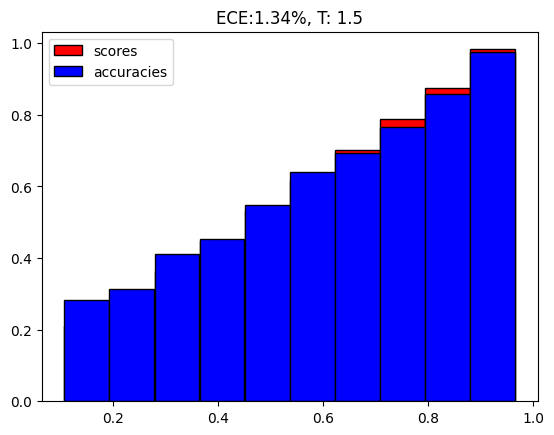

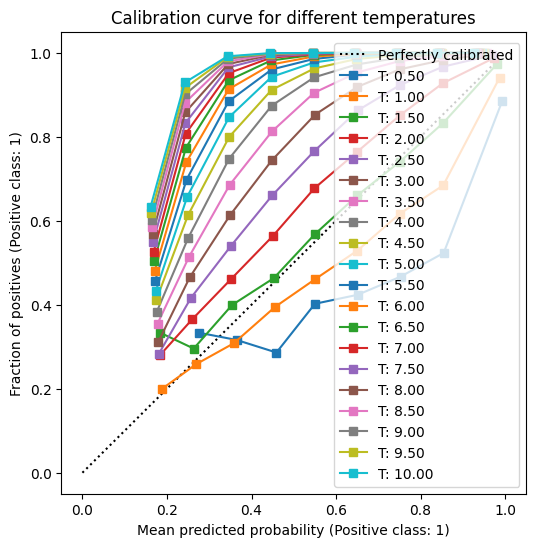

Accuracy: 0.8106


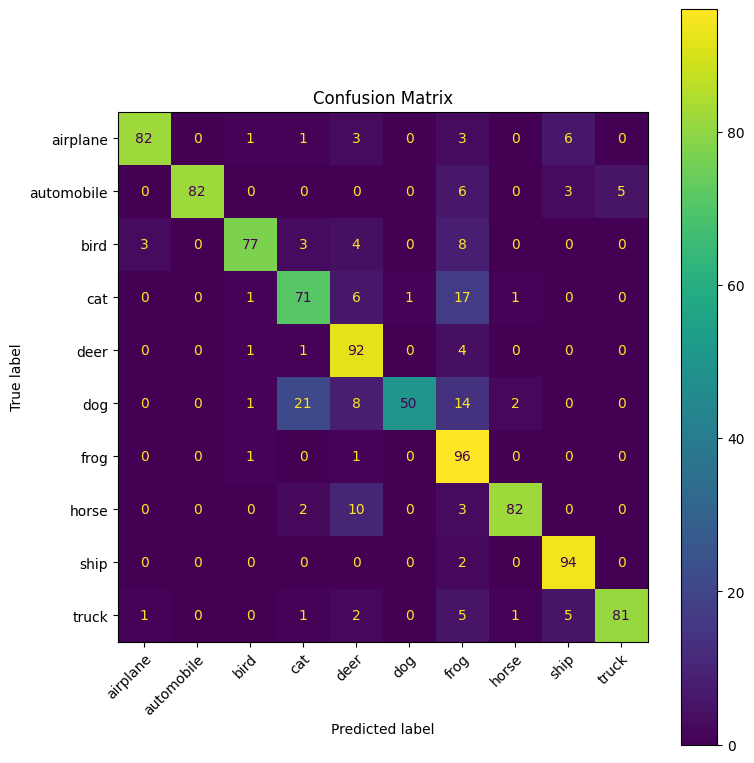

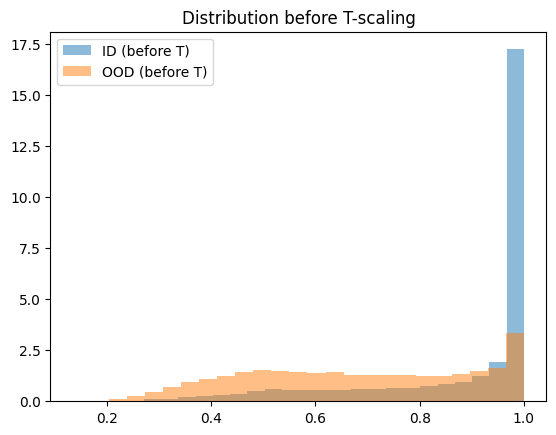

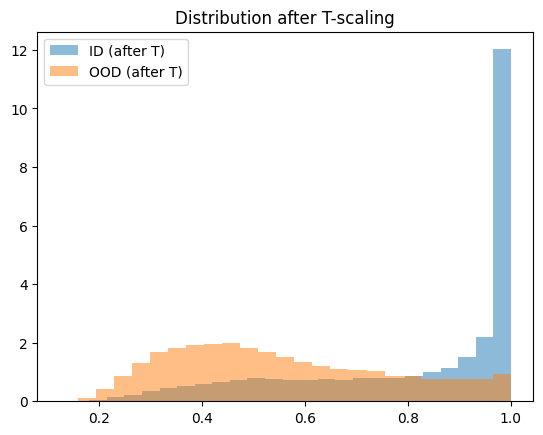

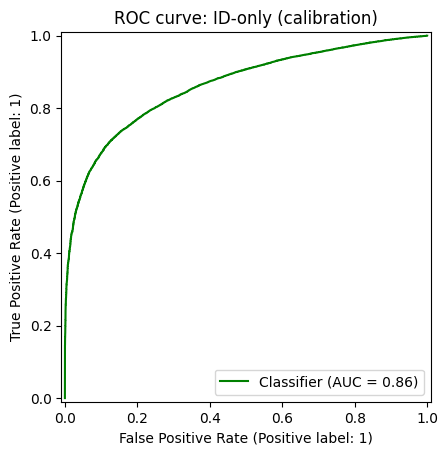

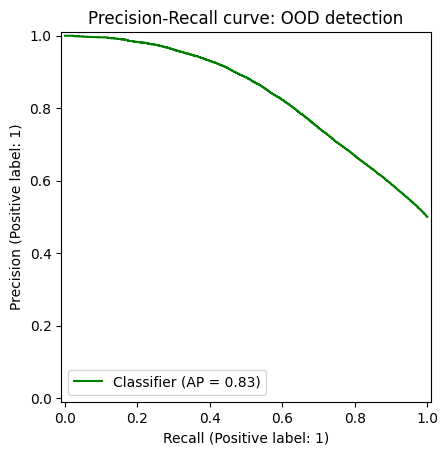

(1.5, 0.013426864014267922)

In [10]:
T_scaling = [x/10 for x in range(5,105,5)]
OOD_pipeline(new_model,'cuda',ds_train,ds_OOD,128,4,T_scaling=T_scaling, plot_performances=True, plot_T_scaling=True)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


In [31]:
classes_dict = {k:v for v,k in enumerate(ds_train.classes)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453315..1.5050403].


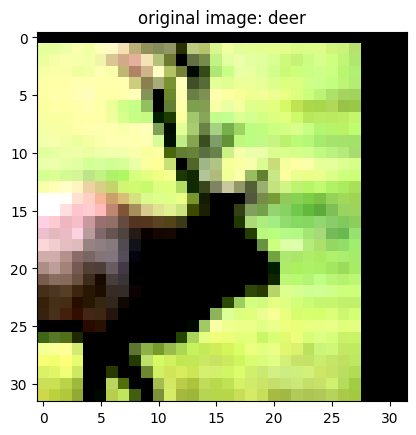

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


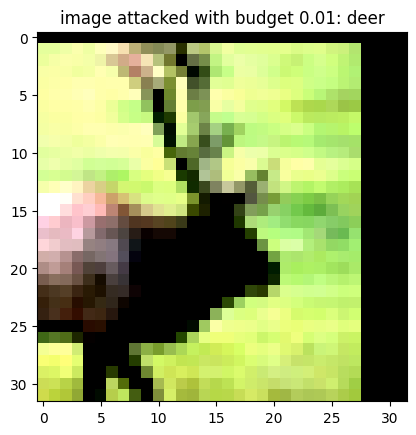

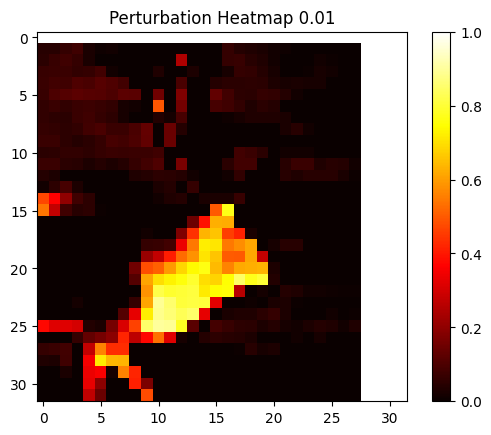

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


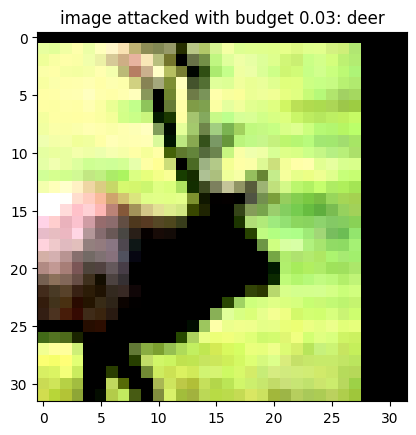

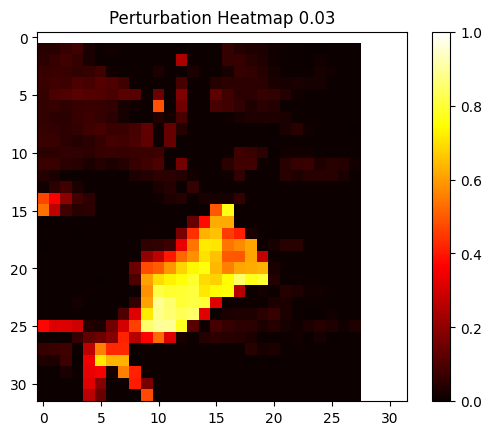

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


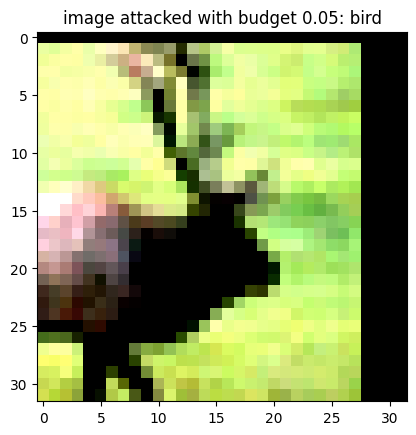

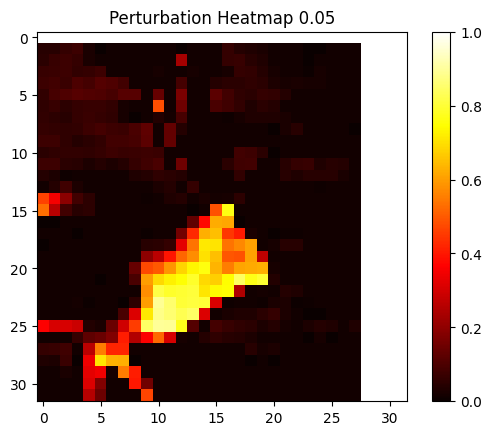

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


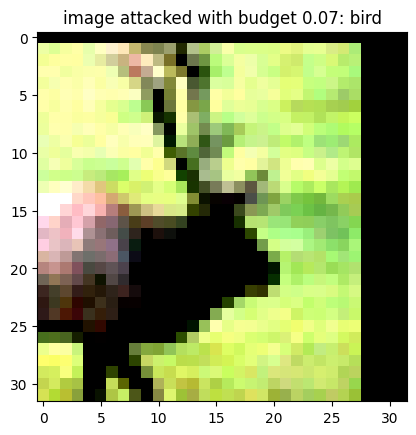

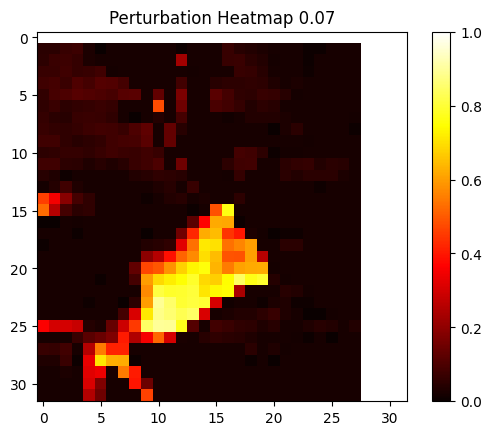

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


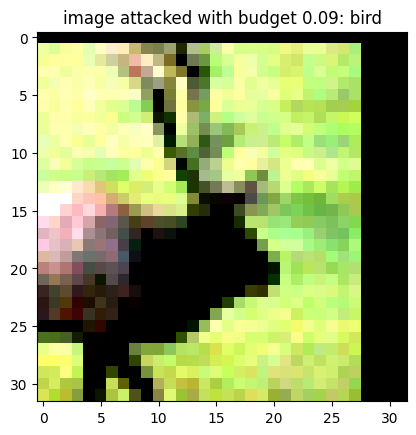

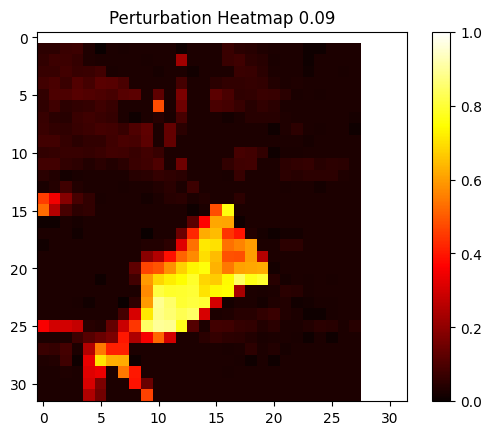

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


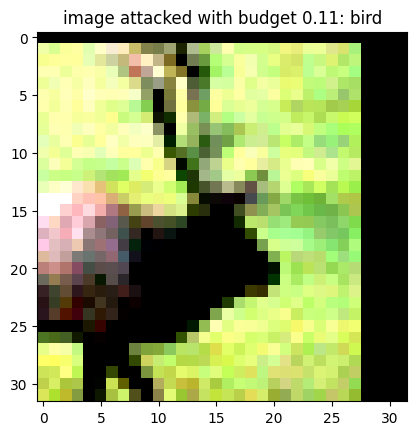

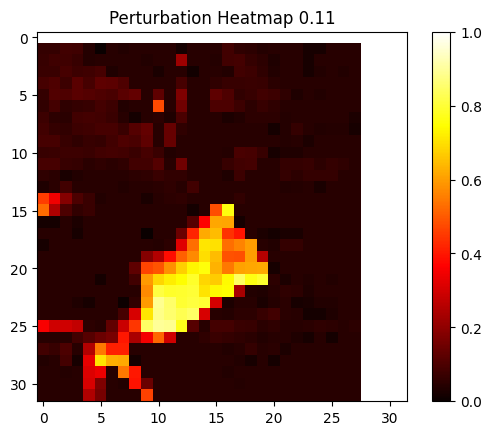

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


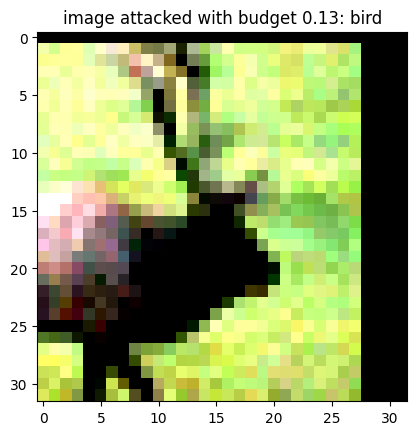

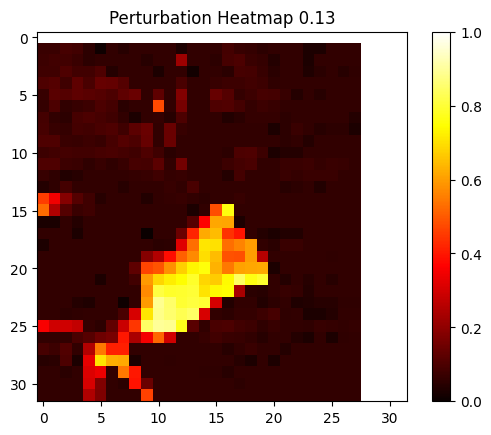

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


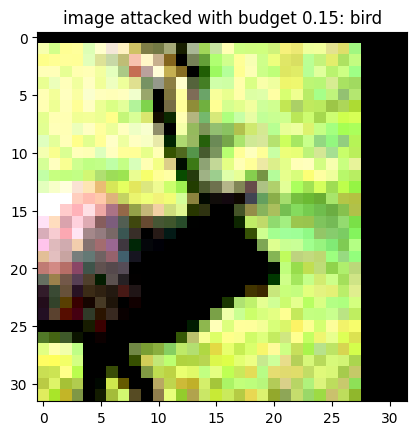

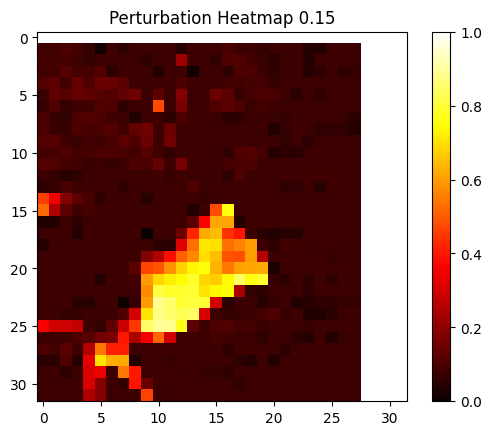

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


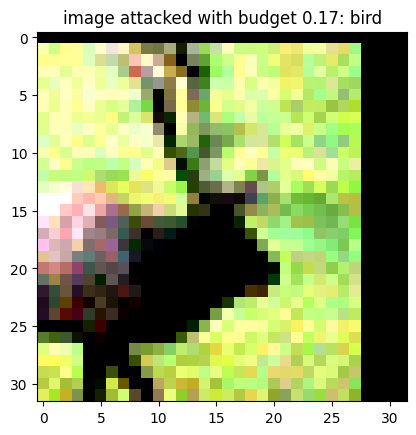

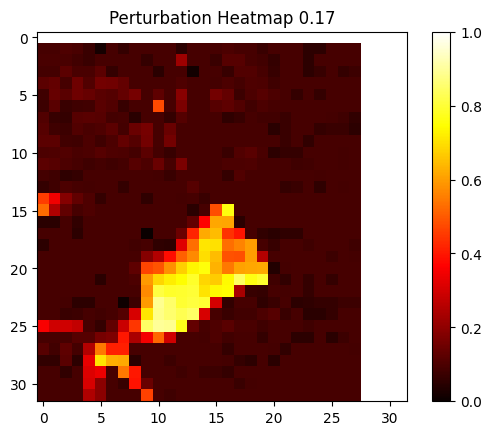

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].


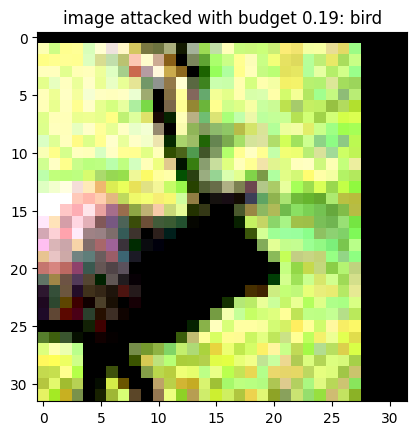

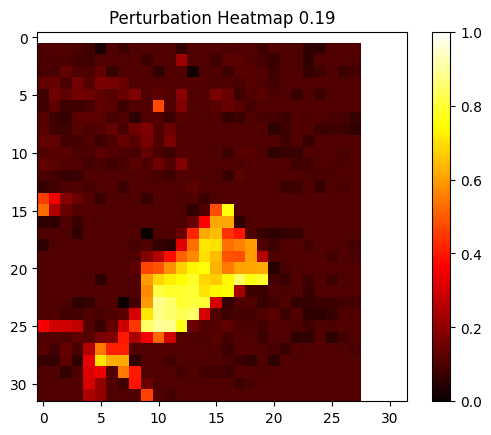

In [42]:
####targeted FGSM evaluation (see fgsm function in training file)
example = ds_train[34]

device = 'cuda'

best_CNN.to(device)


best_CNN.eval()
output_clean = best_CNN(example[0].unsqueeze(0).to(device))

img = inv(example[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title('original image' + ': ' + str(ds_train.classes[output_clean.argmax()]))
plt.show()


y_target = classes_dict['bird']

#qualitative evaluation
for budget in range(1,20,2):
    budget = budget/100
    x_adv = FGSM(x = example[0].unsqueeze(0).to(device),y_true=None,model = best_CNN,budget=budget, y_target=y_target)
    output = best_CNN(x_adv.to(device))

    img_adv = inv(x_adv[0])
    plt.imshow(img_adv.permute(1,2,0).detach().cpu())
    plt.title('image attacked with budget' +' ' + str(budget) + ': ' + ds_train.classes[output.argmax()])
    plt.show()

    diff = (x_adv.cpu() - example[0]).squeeze(0)

    heatmap = diff.abs().sum(dim=0)
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    plt.imshow(heatmap.detach().cpu(), cmap='hot')
    plt.title("Perturbation Heatmap" + ' ' + str(budget))
    plt.colorbar()
    plt.show()


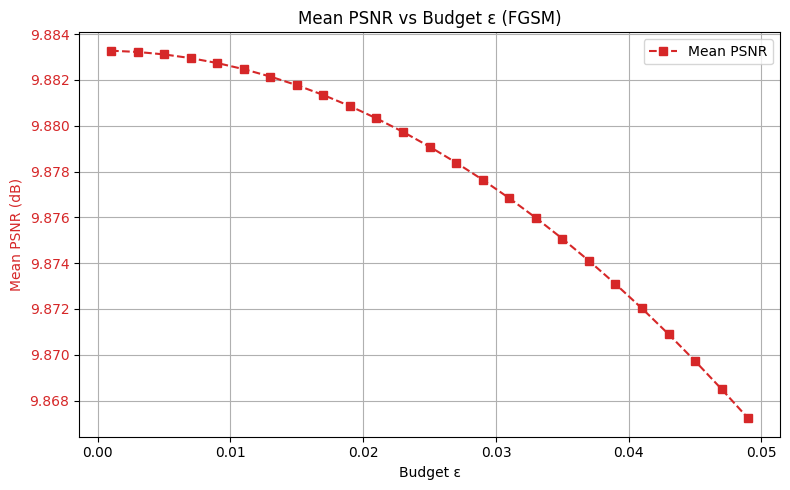

In [44]:
# Quantitative evaluation (solo PSNR)
device = 'cuda'
psnr_list = []

budgets = [b / 1000 for b in range(1, 50, 2)]

correctly_classified = []

index = 0
while len(correctly_classified) <= 100:
    best_CNN.eval()
    output = best_CNN(ds_train[index][0].unsqueeze(0).to(device))
    y_pred = output.argmax()

    if y_pred == ds_train[index][1]:
        correctly_classified.append(ds_train[index])

    index += 1

# Calcolo PSNR
for budget in budgets:
    psnr_sum = 0.0

    for x, y in correctly_classified:
        x = x.unsqueeze(0).to(device)
        x_adv = FGSM(x=x, y_target=y_target, model=best_CNN, budget=budget)

        mse = F.mse_loss(x_adv, x).item()
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 10 * np.log10(4.0 / mse)
        psnr_sum += psnr

    psnr_list.append(psnr_sum / len(correctly_classified))

# Plot PSNR
fig, ax = plt.subplots(figsize=(8, 5))
color_psnr = 'tab:red'
ax.set_xlabel('Budget ε')
ax.set_ylabel('Mean PSNR (dB)', color=color_psnr)
ax.plot(budgets, psnr_list, marker='s', linestyle='--', color=color_psnr, label='Mean PSNR')


ax.tick_params(axis='y', labelcolor=color_psnr)
plt.title('Mean PSNR vs Budget ε (FGSM)')
plt.grid(True)
ax.legend(loc='best')
plt.tight_layout()
plt.show()
